# Creditworthiness model: design
This model will be built upon LendingClub data to evaluate an individual's credit worthiness. The data contains rows of customers, with each column showing the features for loan applications that have been approved, together with outcomes of the loans (in the final column).  The outcomes show that each customer has either defaulted or completed their loan.

#### Requirements
* The model must use logistic regression.
* The model should use 70% of the data to build the model, and the remaining 30% to test.

#### Outputs
The model will return the credit worthiness of an individual as a 0 (creditworthy) or a 1 (uncreditworthy). It shall employ graphical representations of the data to understand model performance

#### Objectives
1. Assuming this model is held by a lender or financial intermediary, the function of the model will likely be to quantify risk: to understand who to provide a loan to or at what rate. It is important to both maximise the number of lending possibilities (detection of 'creditworthy' applicants) and minimise the number of poor lending decisions (detection of 'uncreditworthy' applicants). Arguably, the lender or intermediary will experience greater financial loss from a loan to an applicant who fails to repay than from a missed opportunity to a borrower who would have repaid. As such, whilst an objective of this model should be to maximise lending possibilities (maximise precision), it is perhaps of more importance to circumvent poor lending decisions (maximise recall). 'F1 Score' combines precision and recall via their harmonic mean, weighting the two evenly. <p style="text-align: center;">*'F2 Score' = (1 + B^2) * (precision + recall) / (B^2 * precision + recall)* where B >= 1.</p>
In future, this model could be adapted to use the 'F_beta Score' to evaluate the model, which still considers both precision and recall but allocates a larger weighting to the latter when beta > 1.
2. The model should perform as well as possible on new data - it should generalise well.

In [1]:
## Third-party libraries
import numpy as np
import pandas as pd
import datetime
from random import shuffle, sample
import itertools
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Scikit-learn
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, auc, roc_auc_score, roc_curve, confusion_matrix

# Configuration
%matplotlib inline
fpath = './data/'
fname = 'data.csv'
debug = False
oversampling = True
undersampling = True

## Data Processing
### Preparation
Data preparation steps uncovered during data exploration.

In [2]:
df = pd.read_csv(fpath + fname, header=0)
df = df.drop(df.index[7666]) #Problematic index identified in exploration
df = df.sample(frac=1).reset_index(drop=False) #Maintain indexes in a column
print 'Shape before preprocessing: {}'.format(df.shape)

# Map class
df['Class'] = df['Class'].map({'Uncreditworthy': 1, 'Creditworthy': 0})

# Employment length
df['Employment Length'] = pd.cut(x=df['Employment Length'], bins=11, labels=[x for x in range(11)])

# Loan term
df['Loan Term'] = df['Loan Term'].map(lambda x: int(x[0:2]))

# No. Delinquencies In Last 2 Years
dict_ndil2y = {'Three': 'ThreeOrMore', 
        'Four': 'ThreeOrMore', 
        'Five': 'ThreeOrMore', 
        'Six': 'ThreeOrMore',
        'Seven': 'ThreeOrMore',
        'Eight': 'ThreeOrMore', 
        'Nine': 'ThreeOrMore'
        }
df['No. Delinquencies In Last 2 Years'].replace(dict_ndil2y, inplace=True)

# No. Adverse Public Records
df['No. Adverse Public Records'] = df['No. Adverse Public Records'].map(lambda x: int(x != 'None'))
df.rename(columns={'No. Adverse Public Records': 'Adverse Public Records?'}, inplace=True)

# No. Of Public Record Bankruptcies
df['No. Of Public Record Bankruptcies'] = df['No. Of Public Record Bankruptcies'].map(lambda x: int(x != 'None'))
df.rename(columns={'No. Of Public Record Bankruptcies': 'Public Record Bankruptcies?'}, inplace=True)

# Earliest Credit Line Opened
def convert_to_year(n):
        ''' Converts n days since 1990 into year'''
        base = datetime.datetime.strptime('01/01/1900', '%d/%m/%Y')
        date = base + datetime.timedelta(days=n)
        return date.year
df['Earliest Credit Line Opened'] = df['Earliest Credit Line Opened'].map(convert_to_year)

# Home ownership
df['Home Ownership'].replace({'NOne': 'OTHER'}, inplace=True)

# Binning Months Since Last Delinquency
df_msld_0 = df['Months Since Last Delinquency'].loc[df['Class'] == 0]
df_msld_1 = df['Months Since Last Delinquency'].loc[df['Class'] == 1]
# Remove obscuring 'zero' values.
df_msld_0 = df_msld_0.loc[df['Months Since Last Delinquency'] > 0]
df_msld_1 = df_msld_1.loc[df['Months Since Last Delinquency'] > 0]
min_not_zero = min(min(df_msld_0), min(df_msld_1), 0.25)
bins = [-0.25, min_not_zero * 0.99, 6, 12, 60, max(df['Months Since Last Delinquency'])]
labels = ['NA', 'x < 6', '6 < x < 12', '12< x < 60', 'x > 60']
df['Months Since Last Delinquency'] = pd.cut(x=df['Months Since Last Delinquency'], bins=bins, labels=labels)

## Binning Loan Application Description
labels = [x for x in range(0, 1100, 100)]
df_lad = pd.cut(x=df['Loan Application Description'], bins=11, labels=labels)
# Use binning system for Loan Application Description
labels = ['x < 100', '100 < x < 200', '200 < x < 300', '300 < x < 400',
          '400 < x < 500', '500 < x < 600', '600 < x < 700', '700 < x < 800',
          '800 < x < 900', '900 < x < 1000', 'x > 1000']
df['Loan Application Description'] = pd.cut(x=df['Loan Application Description'], bins=11, labels=labels)
print 'Shape after preprocessing: {}'.format(df.shape)

Shape before preprocessing: (24775, 22)
Shape after preprocessing: (24775, 22)


#### Modify input distributions
The logistic regression employed at the heart of the model works on the assumption of normally-distributed data. Some of our inputs are skewed, so root transforms are employed to make the features' values approximately Gaussian.

In [3]:
# Plot chief numerical cols
if debug:
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize=(5,10))
    sns.distplot(np.sqrt(df['Loan Amount']), ax=ax1)
    sns.distplot(np.sqrt(df['Annual Income']), ax=ax2) 
    sns.distplot(np.log(df['FICO Credit Score']), ax=ax3)
    sns.distplot(np.sqrt(df['No. Of Credit Lines']), ax=ax4)
    sns.distplot(np.sqrt(df['Total Credit Balance']), ax=ax5)
    plt.tight_layout()

# Root-transform key numerical inputs
df['Loan Amount'] = np.sqrt(df['Loan Amount'])
df['Annual Income'] = np.sqrt(df['Annual Income'])
#df['FICO Credit Score'] = np.log(df['FICO Credit Score']) #does not improve cross val score
df['No. Of Credit Lines'] = np.sqrt(df['No. Of Credit Lines'])
df['Total Credit Balance'] = np.sqrt(df['Total Credit Balance'])

### Imputation
Impute null values in the *Use of Credit Line* feature. Imputation is used for only 51 rows which could also be dropped, but should the dataset be expanded in future imputation may become more important. for this dataset, it is not decided whether dropping the rows or imputing yields a better model.

In [4]:
# For check
a = df['Use Of Credit Line'].sum()
a_imp = df['Use Of Credit Line'].isnull().sum()

# Perform imputation
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
df['Use Of Credit Line'] = imp.fit_transform(df[['Use Of Credit Line']])

# Check mean imputed value is reasonable
b = df['Use Of Credit Line'].sum()
print 'Mean of imputations: {:.2f}'.format((b - a) / float(a_imp))

Mean of imputations: 47.95


### Get dummies
Convert features other than ordinal into multiple columns of ones and zeros. Due to the Dummy Variable Trap a function has been created to remove one of the columns from the Pandas get_dummies output.

In [5]:
def make_dummies(data, name, drop_modal=True, retain=False):
    """ Create dummy columns for unique values in a column using the
    Pandas get_dummies function. Dummy values are included in the
    original dataset. If drop_modal is True, the most common value is
    not included as a dummy column. If retain is True, the original
    column is kept.
    :param data: a Pandas DataFrame, the data to work with
    :param name: a string, the column from which to create dummies
    :param drop_modal: bool, no dummies for the most common value
    :param retain: bool, whether to keep the original column
    """
    try:
        dummies = pd.get_dummies(data[name])
    except IndexError:
        raise IndexError('column {} not found'.format(name))
    # Create headings for new dummy columns and add to dataset
    titles = [' '.join((name, str(i))) for i in dummies.columns]
    data[titles] = dummies
    # Remove modal value if requested
    if drop_modal:
        modal = data[name].mode()
        # Raise warning if more than 1 modal value exists
        if len(modal) > 1:
             print('More than one modal value in {}'.format(name))
        data = data.drop(' '.join((name, str(modal[0]))), 1)
    # Drop the original column if requested
    return data if retain else data.drop(name, 1)

# Convert categorical columns to np.object type
categorical_cols = ['Months Since Last Delinquency', 
                     'Employment Length',
                     'Loan Application Description'
                     ]
for col in categorical_cols:
    df[col] = df[col].astype(np.object)

# Get dummy values for remaining categorical (numpy object) data
for name, column in df.iteritems():
    if column.dtype == np.object:
        df = make_dummies(df, name)
        
print 'Shape of dataset: {}'.format(df.shape)

Shape of dataset: (24775, 107)


#### Further preparation
Correlations reveal that certain features are collinear, which could result in low feature weightings in the classifier when the feature effect is significant. To counter this, some features are merged and others removed.

In [6]:
cor = df.corr()
cor.loc[:,:] = np.tril(cor, k=-1) #returns triangle below diagonal of an array
cor = cor.stack()
print cor[(cor > 0.4) | (cor < -0.4)]

Annual Income                 Loan Amount                0.438026
Use Of Credit Line            FICO Credit Score         -0.577934
                              Total Credit Balance       0.491548
Total Number Of Credit Lines  No. Of Credit Lines        0.676549
Public Record Bankruptcies?   Adverse Public Records?    0.878347
dtype: float64


In [7]:
## Changes identified through correlation
# Merge bankruptcies and other adverse records to boolean
df['Adverse Event?'] = df['Public Record Bankruptcies?'] + df['Adverse Public Records?']
df['Adverse Event?'].map(lambda x: np.sum(x > 0))
print 'Adverse Events: {}'.format(np.sum(df['Adverse Event?']))
# Merge No. Of Credit Lines into percentage of credit lines remaining
df['Credit Line Pc Remaining'] = 1 - df['No. Of Credit Lines'] / df['Total Number Of Credit Lines']

drop_cols = ['Public Record Bankruptcies?',
             'Adverse Public Records?',
             'Use Of Credit Line',
             'Total Number Of Credit Lines']
df.drop(drop_cols, axis=1, inplace=True)
print 'Shape of dataset: {}'.format(df.shape)

Adverse Events: 2299
Shape of dataset: (24775, 105)


### Addressing imbalance: over-sampling and under-sampling

In [8]:
if oversampling:
    print 'Shape before oversampling: {}'.format(df.shape)
    idx_minority = df[df['Class'] == 1].index.tolist()
    print 'Total minority cases: {}'.format(len(idx_minority))
    shuffle(idx_minority)
    # Remove top 30% for cross validation
    idx_minority_cv = idx_minority[0:int(len(idx_minority)*0.3)]
    try:
        idx_minority_cv.remove('24775') #quick fix; problematic index
    except:
        pass
    minority_cv = df.loc[idx_minority_cv]
    minority_cv.drop('index', axis=1, inplace=True) #Drop index (used for test set only)
    print 'Minority cases stored for cv: {}'.format(len(idx_minority_cv))
    
    # Using remainder, create copy of random 50% subsample
    idx_minority = idx_minority[int(len(idx_minority)*0.3):]
    print 'Minority cases remaining for oversampling: {}'.format(len(idx_minority))
    shuffle(idx_minority)
    idx_minority_os = idx_minority[0:int(len(idx_minority)*0.5)]
    minority_os = df.loc[idx_minority_os]
    print 'Minority cases oversampled: {}'.format(len(idx_minority_os)) 
    
    # Drop cv from data so the rows can't be used to train the model 
    df.drop(df.index[idx_minority_cv], axis=0, inplace=True)
    # Add os to data to complete oversampling
    df = pd.concat([df, minority_os])
    df.reset_index(drop=True, inplace=True)
    print 'Shape after oversampling: {} + {} held out.'.format(df.shape,
                                                               len(idx_minority_os)
                                                              )
    
if undersampling:
    print '\nShape before undersampling: {}'.format(df.shape)
    count_minority = len(df[df['Class'] == 1]) 
    idx_majority = df[df['Class'] == 0].index.tolist()
    shuffle(idx_majority)
    idx_majority_us = idx_majority[0:len(idx_majority)-count_minority]
    df.drop(df.index[idx_majority_us], axis=0, inplace=True)
    print 'Shape after undersampling: {}, split "0":"1" = {}:{}'.format(df.shape, 
                                                              len(df[df['Class'] == 0]), 
                                                              len(df[df['Class'] == 1])
                                                             )

Shape before oversampling: (24775, 105)
Total minority cases: 4502
Minority cases stored for cv: 1350
Minority cases remaining for oversampling: 3152
Minority cases oversampled: 1576
Shape after oversampling: (25001, 105) + 1576 held out.

Shape before undersampling: (25001, 105)
Shape after undersampling: (9456, 105), split "0":"1" = 4728:4728


### Splitting the dataset
Before any transformation operations are applied which could cause a data leak (e.g. scaling, principal component analysis and cross-validation) the dataset is divided into training and test sets. 

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    df, df['Class'], test_size=0.3, random_state=21
    )

# Drop Class column from X_train and X_test
# X_test retains original index as extra column
X_train.drop(['index', 'Class'], axis=1, inplace=True)
X_test.drop('Class', axis=1, inplace=True)

print 'Size of X_train: {} ({:.1f}% of data)'.format(X_train.shape, 
                                                     len(X_train)*100/float(len(df))
                                                    )
print 'Size of X_test:  {} ({:.1f}% of data)'.format(X_test.shape,
                                                     len(X_test)*100/float(len(df))
                                                    )

Size of X_train: (6619, 103) (70.0% of data)
Size of X_test:  (2837, 104) (30.0% of data)


C:\Users\bw8\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\bw8\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Normalise the data
The data is normalised to assist convergence of the gradient descent algorithm at the heart of the model. It would also be necessary if PCA were used to maximize the variance of each component.

In [10]:
def perform_scaling(d):
    ''' Scales data using pre-fit 'scaler', maintaining DataFrames. '''
    col_names = d.columns
    col_idx = d.index
    return pd.DataFrame(scaler.transform(d), columns=col_names, index=col_idx)

# Maintain test index whilst scaling
test_index = X_test['index']
X_test.drop('index', axis=1, inplace=True)

scaler = StandardScaler().fit(X_train)
X_train = perform_scaling(X_train)
X_test = perform_scaling(X_test)

X_test.loc[:, 'index'] = test_index

# Scale oversampled cross validation set, too
if oversampling:
    y_minority_cv = minority_cv['Class']
    minority_cv.drop('Class', axis=1, inplace=True)
    X_minority_cv = perform_scaling(minority_cv) 

C:\Users\bw8\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Cross-validation
Feature selection and model selection are performed within a cross-validation loop. A ShuffleSplit validation is used due to the limited amount of data available: it maximises the training data used by omitting the need for a dedicated cross-validation dataset, without permitting data leaks in each fold. A stratified cross validation strategy is used to ensure that relative *Class* frequencies are approximately preserved in each train and validation fold, especially given that the dataset is imbalanced.

### Feature Selection
Feature selection is performed to identify and use only the most predictive features. A simpler model is better for multiple reasons, including being easier to put into a production environment, often generalising more effectively to new cases and being simpler to conceptualise by humans. An F1 scoring strategy is used for feature selection for the reasons decribed in Objective 1, though other scoring strategies such as F_beta (beta > 1) could be used depending on the relative importance or precision and recall.

#### Recursive feature elimination
Use RFECV, a backward-search, cross-validated wrapper method for feature selection. As class imbalance is addressed through over/undersampling, the model is able to use the 'accuracy' metric to select the number of features coming out of the RFE. Through cross validation it was determined that the performance increase is minimal, but the variance of the result is significantly reduced.

In [11]:
def get_key(item):
    return item[1]

def feature_selection_RFE(X_train, y_train, cv, debug=False):
    """ Takes a training set and performs recursive feature elimination.
    Returns a list of the best columns for predicting y from X in the
    current cross-validation fold.
    :param X: pandas DataFrame, cleaned training dataset
    :param y: pandas Series or DataFrame, containing Class
    :param cv: cross-validation strategy
    :param estimator: Classification model, e.g. logistic regression.
    :param debug: Boolean, option to turn on/off score vs # features plot
    """

    # Choose classifier for RFE
    clf = LogisticRegression(C=10, random_state=1992) #class_weight='balanced',

    # Set up a recursive feature elimination selector, with cross-validation
    step = 1
    selector = RFECV(clf, step=step, cv=StratifiedKFold(5), scoring='accuracy', verbose=1)
    selector.fit(X_train, y_train)

    # Determine best score and associated features
    f1_rfe = selector.grid_scores_[(len(X_train.columns)-selector.n_features_)/step]
    names_rfe = [(n, gs) for n, gs, s in zip(X_train.columns, selector.ranking_, selector.support_) if s]
    names_rfe = sorted(names_rfe, key=get_key)
    names_rfe = [n for n, gs in names_rfe]
    
    # Debugging / detail
    if debug:
        print 'Original number of features:  %i'.format(len(X_train.columns))
        print 'Number of features after RFE: %i'.format(selector.n_features_)
        print 'Best RFE f1 score: {:.3f}, using {} features.'.format(f1_rfe, len(names_rfe))
        # Plot number of features against cross-validation scores
        plt.figure()
        plt.xlabel('Number of features selected')
        plt.ylabel('Cross validation score (greater is better)')
        plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
        plt.show()

    X_train_rfe = X_train[names_rfe]
    return names_rfe

#### Forward feature selection
A forward feature (filter) selection method was also attempted.

def feature_selection_FFS(X_train, y_train, cv, debug=False):
    """
    TBC
    """

    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)

    # Manual forward feature selection requires CV
    # GBM is intensive; use only three splits
    
    scores_skf = []
    cv_skf = StratifiedKFold(n_splits=3, random_state=7)
    for cv_train_idx, cv_cv_idx in cv_skf.split(X_train, y_train):
        X_train_skf = X_train.loc[cv_train_idx]
        y_train_skf = y_train.loc[cv_train_idx]
        X_cv_skf = X_train.loc[cv_cv_idx]
        y_cv_skf = y_train.loc[cv_cv_idx]
        
        # Fit with ExtraTreesClassifier to make use of the feature_importances_ attribute
        clf = ExtraTreesClassifier(n_estimators=300, random_state=2017)
        clf.fit(X_train_skf, y_train_skf)
        feat_imp = clf.feature_importances_
        feat_imp_sorted = sorted(feat_imp, reverse=True)
        if False:
            feat_imp_sorted_c = sorted(zip(X_train_skf.columns, clf.feature_importances_), key=get_key)[::-1]
            print 'Feature importance before GBM (first 5): {}\n'.format(feat_imp_sorted_c[0:5])

        # Use GBM to evaluate performance, adding features in order of determined importance
        clf = GradientBoostingClassifier(n_estimators=200, random_state=2017)
        total_features = X_train_skf.shape[1]
        f1_ffs = 0
        for feats in range(10, total_features + 1, 3):
            threshold_idx = min(len(feat_imp_sorted), feats)
            threshold = feat_imp_sorted[threshold_idx]
            select = feat_imp > threshold
            if any(select): 
                clf.fit(X_train_skf.values[:,select], y_train_skf.values)
                # Evaluate on local cross validation set 
                #tmp_preds = clf.predict(X_cv_cv.values[:, select])
                #tmp_probs = clf.predict_proba(X_cv_cv.values[:, select])[:,1]
                f1 = cross_val_score(clf, X_cv_skf.values[:,select], y_cv_skf.values, scoring='f1').mean()
                #f1 = f1_score(y_test.values, tmp_preds)
                #roc_pred = roc_auc_score(y_test.values, tmp_preds)
                #roc_prob = roc_auc_score(y_test.values, tmp_probs)
                if f1 > f1_ffs:
                    f1_ffs = f1
                    features_ffs = select
                    #np.save('features/clf_sel.npy',select)
                if debug:
                    print 'Completed {}/{}. F1: {:.5f}. Selected {} features.'.format(feats, total_features, f1, np.sum(select))
            else:
                print 'No features selected.'
            if feats >= 80:
                break
        scores_skf.append([f1_ffs, features_ffs])
        
    X_train_ffs = X_train[X_train_skf.columns[features_ffs]]
    
    if debug:
        print scores_skf
        print '\nBest FFS f1 score: {}, using {} features.'.format(f1_ffs, len(X_train_skf.columns[features_ffs]))
        print 'Shape of data before FFS: {}'.format(X_train_skf.shape)
        print 'Shape of data after FFS: {}'.format(X_train_ffs.shape)
    
    return X_train_ffs

### Model Selection
The code below performs model selection by tuning the regularisation parameter 'C' of the logistic regression under cross validation. The parameter is chosen via 'recall' scoring, as this was found to be the most effective in cross-validation.

In [12]:
def tune_hyperparams(X_train, y_train, cv, debug=False):
    clf = LogisticRegression(random_state=1992) #class_weight='balanced', 
    c_range = np.logspace(-2, 2, 5)
    grid_clf = GridSearchCV(estimator=clf, param_grid=dict(C=c_range), cv=cv,
                            n_jobs=1, scoring='recall'
                           )
    grid_clf.fit(X_train, y_train)
    print 'Parameters chosen: {}'.format(grid_clf.best_params_)
    return grid_clf.best_estimator_, grid_clf.best_params_

### Model Evaluation
The evaluation centres around F1, precision and recall. To assist, the Receiver Operator Characteristic curve is plotted to display the true positive / false positive rate, and the confusion matrix is given to indicate where the model is performing poorly or well.

In [13]:
def evaluate_classifier(clf, X_cv, y_cv, cv, debug=False):
    # F1 and accuracy
    cv_f1 = cross_val_score(clf, X_cv, y_cv, cv=cv, scoring='f1')
    cv_prec = cross_val_score(clf, X_cv, y_cv, cv=cv, scoring='precision')
    cv_recc = cross_val_score(clf, X_cv, y_cv, cv=cv, scoring='recall')
    cv_acc = cross_val_score(clf, X_cv, y_cv, cv=cv, scoring='accuracy')
    print 'Cross-validated F1 score:         {:.3f} +/- {:.3f}.'.format(cv_f1.mean(), cv_f1.std())
    print 'Cross-validated precision score:  {:.3f} +/- {:.3f}.'.format(cv_prec.mean(), cv_prec.std())
    print 'Cross-validated recall score:     {:.3f} +/- {:.3f}.'.format(cv_recc.mean(), cv_recc.std())
    print 'Cross-validated accuracy score:   {:.3f} +/- {:.3f}.'.format(cv_acc.mean(), cv_acc.std())
    
    # ROC and AUC
    def plot_roc_curve(fpr, tpr, roc_auc):
        """ Plots ROC curve.
        :param fpr: numpy array, false positive rate by threshold
        :param tpr: numpy array, true positive rate by threshold
        :param roc_auc: float, area under curve
        """
        print ':: Plotting ROC curve'
        plt.figure()
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.plot(fpr, tpr, label='ROC area = {:.2f}'.format(roc_auc))
        plt.plot(np.linspace(0.0, 1.0, 5), np.linspace(0.0, 1.0, 5), 
                 dashes=[3,1], color='grey'
                )
        plt.legend(loc = 'lower right')
        return plt
    
    # Learning curve
    def plot_learning_curves(X, y, cv, estimator, title):
        """ Plots learning curves, which plot the cross-validated training
        and test scores for increasing training set size. Taken and modified 
        from the scikit-learn documentation.
        :param X: pandas DataFrame, cleaned training dataset
        :param y: pandas Series or DataFrame, containing sale price
        :param cv: cross-validation generator or iterable
        :param estimator: a regression model
        :param title: string, title of graph
        """
        print(':: Plotting learning curve...')
        plt.figure()
        plt.title(title)
        plt.xlabel('Training examples')
        plt.ylabel('Score')
        train_sizes, train_scores, test_scores = learning_curve(
            estimator, X, y, cv=StratifiedShuffleSplit(10), 
            train_sizes=np.linspace(0.1, 1.0, 7),
            scoring='f1'
            )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label='Training score')
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label='Cross-validation score')
        plt.legend(loc='best')
        return plt
    
    def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
        """
        This function plots the confusion matrix graphically. Taken and 
        modified from the scikit-learn documentation.
        :param cm: confusion_matrix object
        :param classes: list, containing class names
        :param title: string, title of graph
        :param cmap: list or string, colour map of confusion matrix
        """
        print(':: Plotting confusion matrix...')
        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        plt.grid()
        #print(cm)
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        return plt
    
    if debug:
        # Print ROC curve and AUC
        probs = clf.predict_proba(X_cv)
        fpr, tpr, thresholds = roc_curve(y_cv, probs[:, 1])
        roc_auc = auc(fpr, tpr)
        plot = plot_roc_curve(fpr, tpr, roc_auc) 
        plot.show()
        print 'ROC area under curve: {:.2f}'.format(roc_auc)
       
        # Print learning curve
        title = 'Learning curve (f1 score)'
        plot1 = plot_learning_curves(X_cv, y_cv, cv, clf, title)
        plot1.show()

        # Print confusion matrix
        preds = clf.predict(X_cv)
        conf_matrix = confusion_matrix(y_cv, preds)
        title = 'Confusion matrix'
        plot2 = plot_confusion_matrix(conf_matrix, classes=['Creditworthy', 'Uncreditworthy'], title=title)
        plot2.show()

    return cv_f1.mean(), cv_f1.var()

### Running the pipeline
Now that the model pipeline is constructed, call feature selection and model selection within each cross validation split, then evaluate. Performing both feature selection and model selection within cross validation ensures no data leakage between the two, and optimisation of both parameters in tandem.

In [14]:
# Cross validation strategy: use stratified to maintain class balance
cv_ss = ShuffleSplit(n_splits=10, test_size=0.3, random_state=7)

# Reset indexes for slicing to work
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Perform both feature selection and model selection in cross validation loop
results = []
for train_idx, cv_idx in cv_ss.split(X_train, y_train):
    print '\n-------------- Executing CV fold {} --------------'.format(len(results)+1)
    
    # Cross validation for inner loops
    cv = StratifiedKFold(n_splits=10)

    
    # If using oversampling, inject held out oversampled cv data
    X_cv = pd.concat([X_train.loc[cv_idx], X_minority_cv.sample(frac=0.25)])
    y_cv = pd.concat([y_train.loc[cv_idx], y_minority_cv.sample(frac=0.25)])
    if debug:
        print 'INFO: "0":"1" ratio in train set: {}:{}'.format(
            len(y_train.loc[train_idx])-sum(y_train.loc[train_idx]), 
            len(y_train.loc[train_idx])
            )
        print 'INFO: "0":"1" ratio in CV set:    {}:{}'.format(
            len(y_cv)-sum(y_cv), len(y_cv)
            )

    # Find best features for fold
    print '\n::: Performing feature selection...'
    features = feature_selection_RFE(X_train.loc[train_idx],
                                     y_train.loc[train_idx], 
                                     cv, 
                                     debug
                                    )
    
    # Find best classifier hyperparameters for fold
    print '\n::: Tuning hyperparameters...'
    clf, param_c = tune_hyperparams(X_train[features].loc[train_idx], 
                           y_train.loc[train_idx], 
                           cv, 
                           debug
                          )
    
    # Evaluate tuned classifier performance on the held-out data
    print '\n::: Evaluating classifier...'
    fold_f1_score, fold_f1_var = evaluate_classifier(clf,
                                                     X_cv[features],
                                                     y_cv,
                                                     cv=cv,
                                                     debug=False
                                                    )

    # Append fold's score to list of scores
    results.append([features, param_c, fold_f1_score, fold_f1_var])

print '############## MODEL CROSS VAL SCORE ##############'
f1_lr = np.array([l[2] for l in results]).mean()
std_lr = np.sqrt(sum([l[3] for l in results])) # VAR_x = VAR_y + VAR_z
print 'Cross validated model f1: {:.5f} +/- {:.5f}'.format(f1_lr, std_lr)


-------------- Executing CV fold 1 --------------

::: Performing feature selection...

::: Tuning hyperparameters...
Parameters chosen: {'C': 0.10000000000000001}

::: Evaluating classifier...
Cross-validated F1 score:         0.712 +/- 0.028.
Cross-validated precision score:  0.683 +/- 0.026.
Cross-validated recall score:     0.744 +/- 0.036.
Cross-validated accuracy score:   0.664 +/- 0.032.

-------------- Executing CV fold 2 --------------

::: Performing feature selection...

::: Tuning hyperparameters...
Parameters chosen: {'C': 0.01}

::: Evaluating classifier...
Cross-validated F1 score:         0.713 +/- 0.022.
Cross-validated precision score:  0.673 +/- 0.024.
Cross-validated recall score:     0.758 +/- 0.026.
Cross-validated accuracy score:   0.651 +/- 0.028.

-------------- Executing CV fold 3 --------------

::: Performing feature selection...

::: Tuning hyperparameters...
Parameters chosen: {'C': 0.01}

::: Evaluating classifier...
Cross-validated F1 score:         0.7

## Model evaluation using full training set
A model is now created using the full training set, evaluated on the held out test data. The model development above has guided design parameters of the pipeline through use of the cross-validation score, so the model is now able to use the best features and best regularisation term ('C') to evaluate entirely new data to a similar performance. 

In [19]:
# Find the best features and parameters from CV
f1_scores = [r[2] for r in results]
best_run = results[f1_scores.index(max(f1_scores))]
best_features, best_c = best_run[0], best_run[1] 


::: Training classifier...

::: Evaluating classifier...
Cross-validated F1 score:         0.671 +/- 0.074.
Cross-validated precision score:  0.685 +/- 0.078.
Cross-validated recall score:     0.663 +/- 0.095.
Cross-validated accuracy score:   0.678 +/- 0.068.
:: Plotting ROC curve


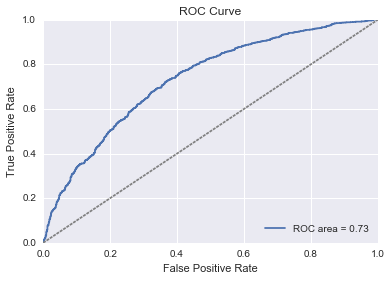

ROC area under curve: 0.73
:: Plotting learning curve...


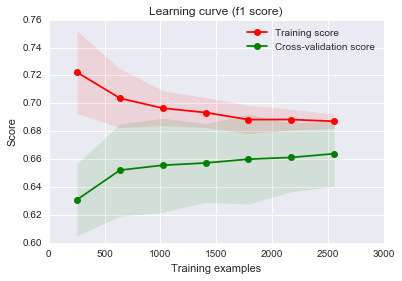

:: Plotting confusion matrix...


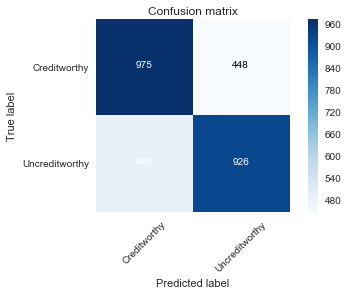

In [16]:
# Try on held out TEST data
cv = StratifiedKFold(n_splits=50)

# Removed - use parameters from best cross validation run
#print '\n::: Performing feature selection...'
#features = feature_selection_RFE(X_train, y_train, cv, debug=True)

print '\n::: Training classifier...'
clf = LogisticRegression(C=best_c['C'], random_state=18)
clf.fit(X_train[best_features], y_train)

print '\n::: Evaluating classifier...'
fold_f1_score, fold_f1_var = evaluate_classifier(clf, X_test[best_features],
                                                 y_test, cv=cv,
                                                 debug=True
                                                )

## Outputs
Model outputs depend on the user's requirements. Currently, the outputs are available through clf.predict(X_test, y_test).
* The 'predict proba' method of the classifier can be used to output the probability that the borrower is expected to default.
* The results can be placed into a .csv file.
* The results can be fed to other systems.
* Etc.

In [17]:
probabilities = clf.predict_proba(X_test[best_features])[:,1]
# Outputs to be decided

#### Feature importances

In [18]:
def get_key_abs(item):
    return abs(item[1])

feat_list = zip(X_test[best_features].columns, clf.coef_[0])
print 'Features used, in order of importance: \n'
for item in sorted(feat_list, key=get_key_abs, reverse=True):
    print item[0], ': ', round(item[1],3)

Features used, in order of importance: 

FICO Credit Score :  -0.409
Loan Term :  0.392
Annual Income :  -0.322
Loan Purpose Small Business :  0.252
No. Inquiries In Last 6 Months :  0.228
Loan Amount :  0.137
Loan Purpose Credit Card :  -0.121
Debt To Income Ratio :  0.115
Credit Line Pc Remaining :  -0.114
Total Credit Balance :  0.102
Adverse Event? :  0.093
Loan Purpose Medical :  0.092
Loan Purpose Other :  0.091
Address State WY :  -0.09
Loan Purpose Renewable Energy :  0.088
Address State NE :  0.086
Address State NY :  -0.083
Address State MI :  -0.083
Loan Application Description 800 < x < 900 :  -0.08
Earliest Credit Line Opened :  -0.08
Loan Application Description 700 < x < 800 :  -0.072
Loan Purpose Car :  -0.064
Months Since Last Delinquency 12< x < 60 :  -0.059
Loan Purpose Home Improvement :  0.059
Address State NV :  0.058
Address State VA :  -0.058
No. Of Credit Lines :  -0.055
Employment Length 9 :  -0.054
Months Since Last Delinquency 6 < x < 12 :  -0.054
Address St

## Future expansion

### Addressing bias and variance
The model has fairly low variance, but does suffers from moderately high bias. Whilst obtaining more of the same data is always helpful, the effect of more data on reducing bias is minimal - instead, one could try increasing model complexity. This can be done by either:
#### Adding conjugate features
Combinations of features allow the linear model to see a new dimension, increasing model complexity and potentially reducing bias. However, model run time is likely to scale similarly.
#### Collecting more relevant data
Further features, such as personality traits determined from social media records, could be used to assist the model in getting a better picture of the applicant and situation.

### Using a weighted scoring mechanism
If detection of uncreditworthy applicants is more important than incorrectly labelling applicants as uncreditworthy when they were in fact not, then a weighted scoring mechanism could be used to guide the model. For example, F_beta scoring where beta > 1.

### Dimensionality reduction
Principal component analysis or factor analysis could be used to reduce the number of features further, by combining correlated features to create new features. However, this makes the model considerably more complicated to describe as the original features become unrecognisable. Given that this model will be used to evaluate creditworthiness it should, ideally, possess excellent transparency. As such, PCA has not been added, but could be used if increased performance was desired.

### Intelligent oversampling
The current sampling system is 'dumb', taking a proportion of the records and duplicating them (injecting them back only during cross validation as not to introduce a data leak). This could be improved by creating *similar*, rather than *duplicate* data. A useful technique to consider is SMOTE.

### Use of a more sophisticated classifier
Logistic regression is an excellent classifer, balancing performance, transparency, training time and ease of implementation. However, many other techniques are available with different advantages and disadvantages. Support Vector Machines, for example, use a different mechanism ('large margin') to separate classes, and can learn highly non-linear relationships leading to increased performance at increased difficulty and reduced transparency.

### Ensembling
Classifiers can be combined (or 'ensembled') to exhibit performance better than the sum of their parts - many reasonable learners can be combined to form an excellent classifier. Whilst difficult to put into production, the performance gains can be significant.

### Reframing the problem as *anomaly detection*
Instead of using a classifier to separate classes, the problem could be reframed as a clustering problem. This may be useful if future default rates are very low.